<a href="https://colab.research.google.com/github/juan026/EVA3D/blob/main/ComputerGraphics_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>




#EVA3D: Compositional 3D Human Generation from 2D Image Collections

*Hong, F., Chen, Z., Lan, Y., Pan, L., & Liu, Z. (2022). Eva3d: Compositional 3d human generation from 2d image collections. arXiv preprint arXiv:2210.04888.*

Juan Antonio Del Hoyo Ontiveros

En este se realiza un revisión y adaptación del código con el fin de evaluarlo.
Este articulo propone un modelo de tipo red generativa antagónica GAN el cual se entrenó a partir de imágenes 2D para crear lo que se conoce como inversión de gráficos, es decir, pasar de representación 2D a 3D. En el método propuesto los autores aplican una división del cuerpo humano en partes locales,  de esta forma pueden enfocar el aprendizaje en las distintas áreas donde se identifican las articulaciones del cuerpo humano. Finalmente, se logra representar las partes articuladas de manera más precisa.


Este demo utiliza el modelo pre-entrenado en la base de datos DeepFashion.


Enlaces:

Original Github Repo: https://github.com/hongfz16/EVA3D

Artículo arXiv Link: https://arxiv.org/abs/2210.04888


In [1]:
# @title Code used for Computer Graphics Project 
# Setup Everything

# Importamos la copia del repositorio e instalamos todas las librerias requeridas por el proyecto
!nvidia-smi
!git clone https://github.com/juan026/EVA3D.git

!pip install torch==1.11.0+cu113 torchvision==0.12.0+cu113 torchaudio==0.11.0 --extra-index-url https://download.pytorch.org/whl/cu113

import sys
import torch
pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
version_str="".join([
    f"py3{sys.version_info.minor}_cu",
    torch.version.cuda.replace(".",""),
    f"_pyt{pyt_version_str}"
])
!pip install fvcore iopath
!pip install --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
!pip install -r EVA3D/requirements.txt

Thu Apr 27 07:37:04 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# @title Download Models

# Se descargan los modelos preentrenados 
%cd EVA3D
from download_models import download_pretrained_models
download_pretrained_models()

/content/EVA3D


100%|██████████| 160M/160M [00:02<00:00, 70.0MB/s]


100%|██████████| 160M/160M [00:01<00:00, 103MB/s]


100%|██████████| 160M/160M [00:02<00:00, 79.4MB/s]


100%|██████████| 158M/158M [00:52<00:00, 3.03MB/s]


Register and download SMPL models [here](https://smpl.is.tue.mpg.de/). Put the downloaded models in the folder smpl_models. Only the neutral one is needed. The folder structure should look like

```
./
├── ...
└── smpl_models/
    ├── smpl/
        └── SMPL_NEUTRAL.pkl
```

In [3]:
# @title Download SMPL NEUTRAL model
!ls
# Descargamos el modelo para la generación de cuerpos humanos en 3D
!mkdir smpl_models
%cd smpl_models
!mkdir smpl
%cd smpl
!ls
!gdown 1DTiAXbVnCRopZ-LObAqKnT-9rv-aySc5
!ls

assets				eva3d_aist.py	      README.md
augment.py			eva3d_deepfashion.py  requirements.txt
calculate_fid.py		generation_demo.py    run_inference.py
checkpoint			LICENSE		      scripts
ComputerGraphics_Project.ipynb	losses.py	      smpl_utils.py
dataset.py			model.py	      torch_utils
distributed.py			notebook	      train_deepfashion.py
dnnlib				op		      utils.py
download_datasets.py		options.py	      volume_renderer.py
download_models.py		__pycache__
/content/EVA3D/smpl_models
/content/EVA3D/smpl_models/smpl
Downloading...
From: https://drive.google.com/uc?id=1DTiAXbVnCRopZ-LObAqKnT-9rv-aySc5
To: /content/EVA3D/smpl_models/smpl/SMPL_NEUTRAL.pkl
100% 39.0M/39.0M [00:00<00:00, 59.3MB/s]
SMPL_NEUTRAL.pkl


In [4]:
# @title Download dataset for training
%cd ../..
!ls
# Se descarga el conjunto de datos Deep Fashion
!python download_datasets.py

Streaming output truncated to the last 5000 lines.
  inflating: datasets/DeepFashion/images/WOMEN-Dresses-id_00000481-03_4_full.png  
  inflating: datasets/DeepFashion/images/MEN-Jackets_Vests-id_00004606-01_4_full.png  
  inflating: datasets/DeepFashion/images/WOMEN-Dresses-id_00002682-03_1_front.png  
  inflating: datasets/DeepFashion/images/WOMEN-Dresses-id_00004354-02_2_side.png  
  inflating: datasets/DeepFashion/images/WOMEN-Tees_Tanks-id_00000212-01_4_full.png  
  inflating: datasets/DeepFashion/images/WOMEN-Pants-id_00004070-05_1_front.png  
  inflating: datasets/DeepFashion/images/WOMEN-Sweaters-id_00003632-04_4_full.png  
  inflating: datasets/DeepFashion/images/MEN-Sweatshirts_Hoodies-id_00006478-01_4_full.png  
  inflating: datasets/DeepFashion/images/WOMEN-Blouses_Shirts-id_00000727-04_7_additional.png  
  inflating: datasets/DeepFashion/images/MEN-Sweatshirts_Hoodies-id_00002533-01_4_full.png  
  inflating: datasets/DeepFashion/images/WOMEN-Blouses_Shirts-id_00004111-06_7

In [ ]:
# @title Train a new model using deepfashion dataset

!python train_deepfashion.py --batch 6 --chunk 1 --expname train_deepfashion_512x256 --dataset_path datasets/DeepFashion --depth 5 --width 128 --style_dim 128 --renderer_spatial_output_dim 512 256 --input_ch_views 3 --white_bg --r1 300 --voxhuman_name eva3d_deepfashion --random_flip --eikonal_lambda 0.5 --small_aug --iter 1000 --adjust_gamma --gamma_lb 20 --min_surf_lambda 1.5 --deltasdf --gaussian_weighted_sampler --sampler_std 15 --N_samples 14


/usr/local/lib/python3.9/dist-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
  0% 0/1 [00:00<?, ?it/s]Marching Cube: 0/5
Marching Cube: 1/5
Marching Cube: 2/5
Marching Cube: 3/5
Marching Cube: 4/5
/usr/local/lib/python3.9/dist-packages/pytorch3d/io/obj_io.py:542: UserWarning: No mtl file provided
  warnings.warn("No mtl file provided")
/usr/local/lib/python3.9/dist-packages/torchvision/utils.py:63: UserWarning: The parameter 'range' is deprecated since 0.12 and will be removed in 0.14. Please use 'value_range' instead.
  warnings.warn(
100% 1/1 [00:23<00:00, 23.43s/it]


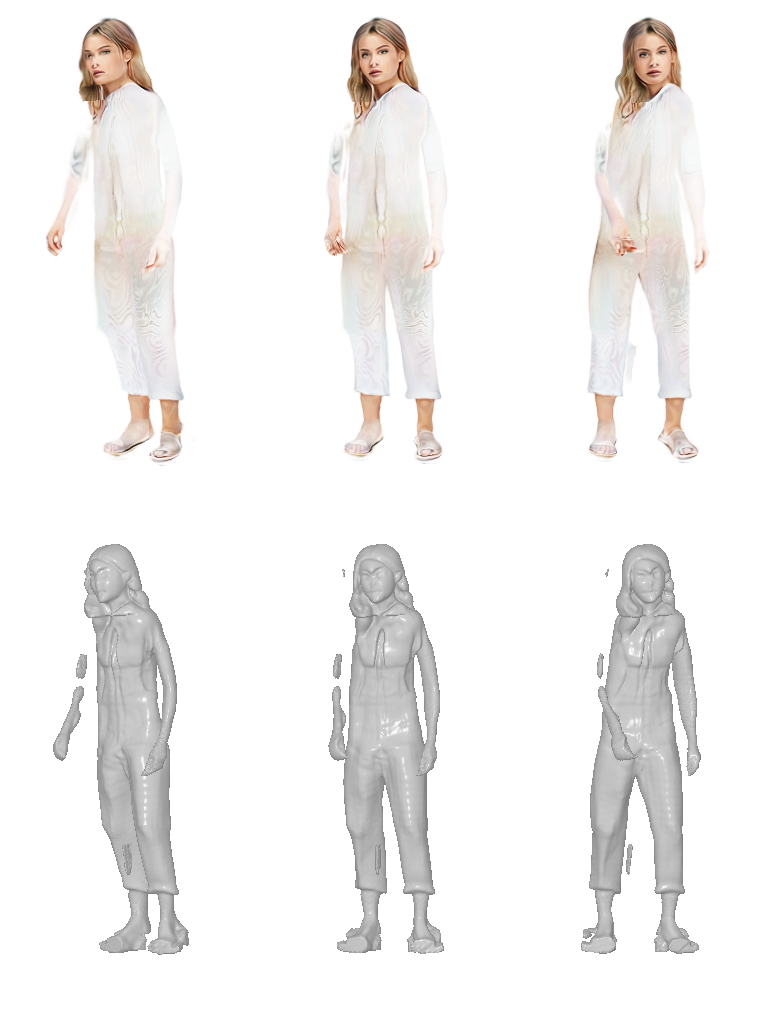

In [15]:

# @title Start the Genenration!
# Ejecutamos la inferencia por defecto
!python generation_demo.py --batch 1 --chunk 1 --expname 512x256_deepfashion --dataset_path demodataset --depth 5 --width 128 --style_dim 128 --renderer_spatial_output_dim 512 256 --input_ch_views 3 --white_bg --voxhuman_name eva3d_deepfashion --deltasdf --N_samples 28 --ckpt 420000 --identities 1 --truncation_ratio 0.5
from IPython.display import Image
Image('evaluations/512x256_deepfashion/iter_0420000/random_angles/images_paper_fig/0000000.png')

In [7]:
# @title Define images for evaluation
import os
# define images for evaluation
# Se definen las rutas con las imagenes de ejemplos 
# seleccionados para evaluar el modelo
root_dataset = "/content/EVA3D/datasets/DeepFashion/images/"

testing_images= ["MEN-Jackets_Vests-id_00005346-01_4_full.png",
                 "WOMEN-Dresses-id_00006993-03_7_additional.png",
                 "WOMEN-Blouses_Shirts-id_00001722-07_7_additional.png"]


img_testing1 = os.path.join(root_dataset, testing_images[0])
img_testing2 = os.path.join(root_dataset, testing_images[1])
img_testing3 = os.path.join(root_dataset, testing_images[2])

In [8]:
# @title Define code for transformation

# Se importan las librerias de OpenCV para aplicar operaciones de 
# transformaciones a las imágenes.
# Run transformations
import cv2
import numpy as np

from google.colab.patches import cv2_imshow





Input Image


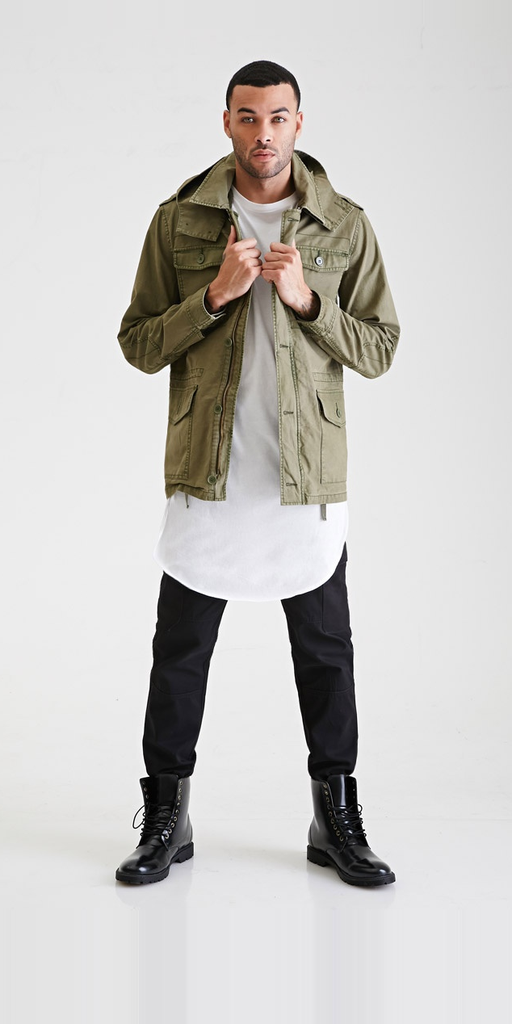

Output Image


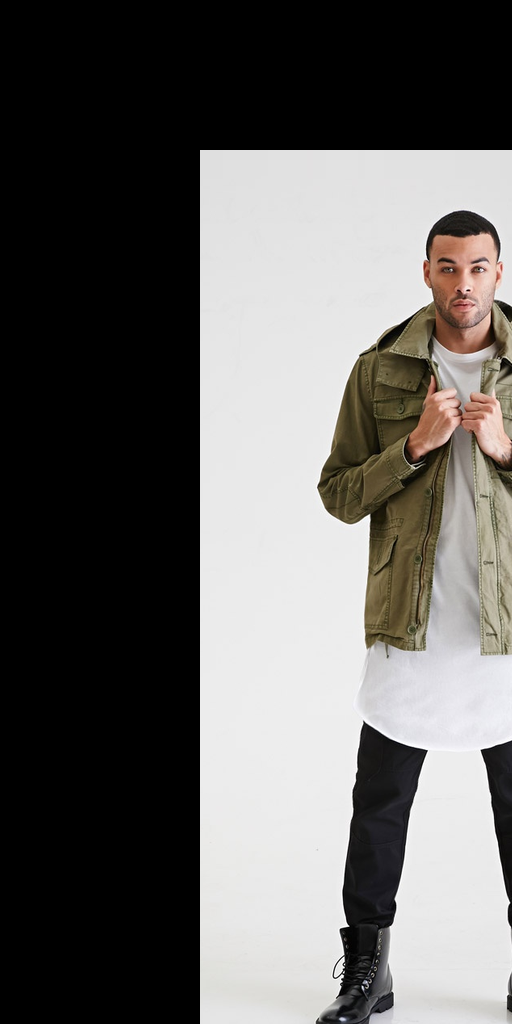

/content/EVA3D/datasets/DeepFashion/images/MEN-Jackets_Vests-id_00005346-01_4_full__translation.png


In [16]:
# @title Transformation: Translation
# Translation
# Se aplica la transformación de traslación en los ejes X,Y con 200 y 150 
# pixeles respectivamente.
image = cv2.imread(img_testing1)
ancho = image.shape[1] #columnas
alto = image.shape[0] # filas

M = np.float32([[1, 0,200],
                [0, 1,150]])
imageOut = cv2.warpAffine(image,M,(ancho,alto))
print('Input Image')
cv2_imshow(image)
print('Output Image')
cv2_imshow(imageOut)
cv2.waitKey(0)
# Se guarda la imagen para su posterior inferencia
# en el modelo.
output_img_path = img_testing1[:-4]+"__translation.png"
print(output_img_path)
cv2.imwrite(output_img_path, imageOut)
cv2.destroyAllWindows()

# save basename image to file for inference
with open("file_test1.txt", "w") as ft1:
  ft1.write(os.path.basename(output_img_path))

/usr/local/lib/python3.9/dist-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
image num: 1
smpl num: 1
  0% 0/1 [00:00<?, ?it/s]Marching Cube: 0/5
Marching Cube: 1/5
Marching Cube: 2/5
Marching Cube: 3/5
Marching Cube: 4/5
/usr/local/lib/python3.9/dist-packages/pytorch3d/io/obj_io.py:542: UserWarning: No mtl file provided
  warnings.warn("No mtl file provided")
/usr/local/lib/python3.9/dist-packages/torchvision/utils.py:63: UserWarning: The parameter 'range' is deprecated since 0.12 and will be removed in 0.14. Please use 'value_range' instead.
  warnings.warn(
100% 1/1 [00:26<00:00, 26.25s/it]


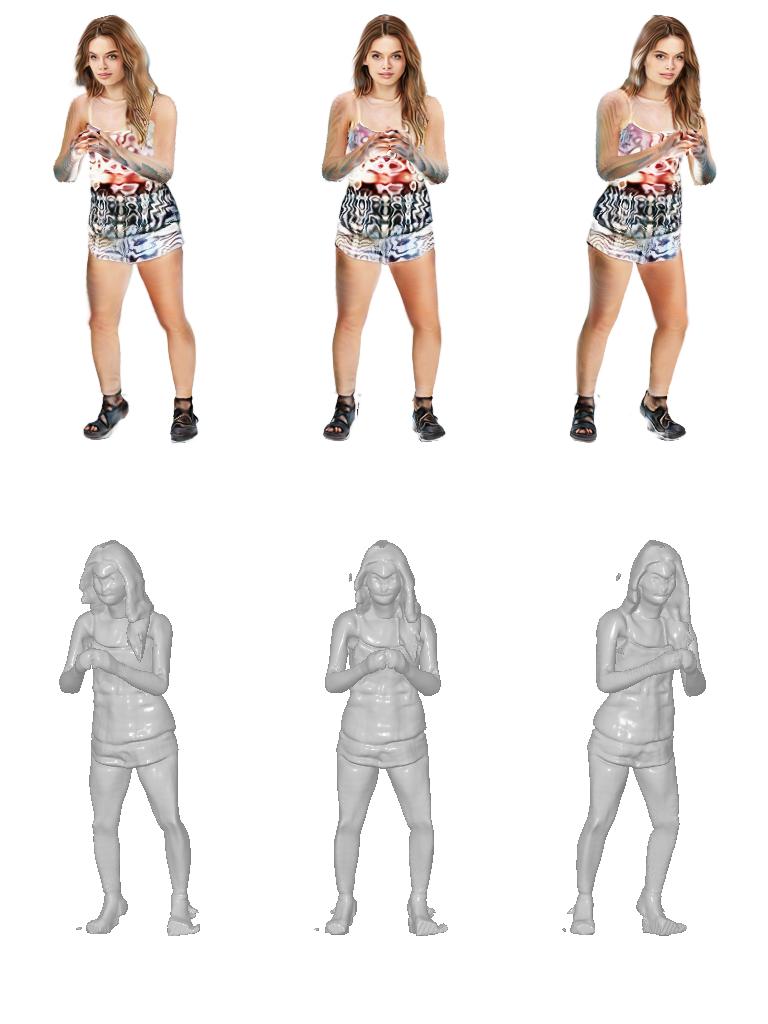

In [17]:
# @title Run inference: Translation
# Ejecutamos la inferencia en la imagen anterior
!python generation_demo.py --batch 1 --chunk 1 --expname 512x256_deepfashion --dataset_path /content/EVA3D/datasets/DeepFashion --depth 5 --width 128 --style_dim 128 --renderer_spatial_output_dim 512 256 --input_ch_views 3 --white_bg --voxhuman_name eva3d_deepfashion --deltasdf --N_samples 28 --ckpt 420000 --identities 1 --truncation_ratio 0.5 --testing_list /content/EVA3D/file_test1.txt
from IPython.display import Image
Image('evaluations/512x256_deepfashion/iter_0420000/random_angles/images_paper_fig/0000000.png')

Input Image


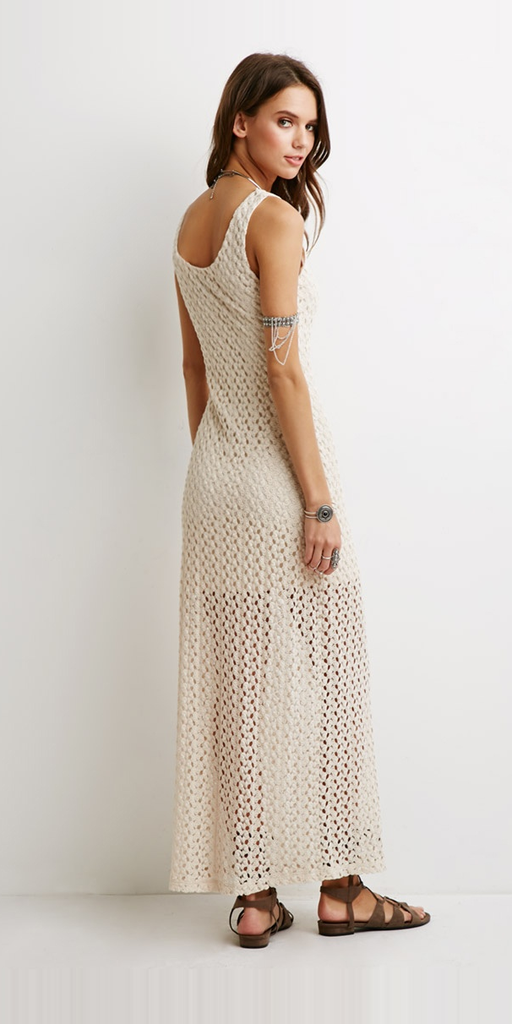

Output Image


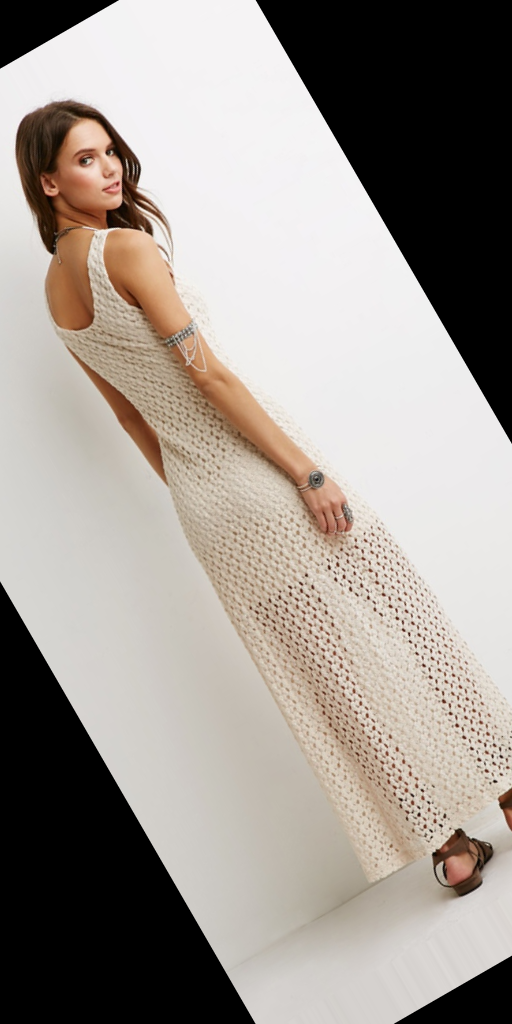

/content/EVA3D/datasets/DeepFashion/images/WOMEN-Dresses-id_00006993-03_7_additional__rotation.png


In [18]:
# @title Transformation: Rotation
# Rotation
# Se aplica la transformación de rotación usando como eje de rotación 
# el centro dividiendo por 2 su tamaño, después se rota 30 grados sobre el eje
# y no se aplica ningún escalamiento.
# pixeles respectivamente.
image = cv2.imread(img_testing2)
ancho = image.shape[1] #columnas
alto = image.shape[0] # filas
# Rotación
M = cv2.getRotationMatrix2D((ancho//2,alto//2),30,1)
imageOut = cv2.warpAffine(image,M,(ancho,alto))
print('Input Image')
cv2_imshow(image)
print('Output Image')
cv2_imshow(imageOut)
# Se guarda la imagen para su posterior inferencia
# en el modelo.
output_img_path = img_testing2[:-4]+"__rotation.png"
print(output_img_path)
cv2.imwrite(output_img_path, imageOut)
cv2.waitKey(0)
cv2.destroyAllWindows()

# save basename image to file for inference
with open("file_test1.txt", "w") as ft1:
  ft1.write(os.path.basename(output_img_path))

/usr/local/lib/python3.9/dist-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
image num: 1
smpl num: 1
  0% 0/1 [00:00<?, ?it/s]Marching Cube: 0/5
Marching Cube: 1/5
Marching Cube: 2/5
Marching Cube: 3/5
Marching Cube: 4/5
/usr/local/lib/python3.9/dist-packages/pytorch3d/io/obj_io.py:542: UserWarning: No mtl file provided
  warnings.warn("No mtl file provided")
/usr/local/lib/python3.9/dist-packages/torchvision/utils.py:63: UserWarning: The parameter 'range' is deprecated since 0.12 and will be removed in 0.14. Please use 'value_range' instead.
  warnings.warn(
100% 1/1 [00:24<00:00, 24.62s/it]


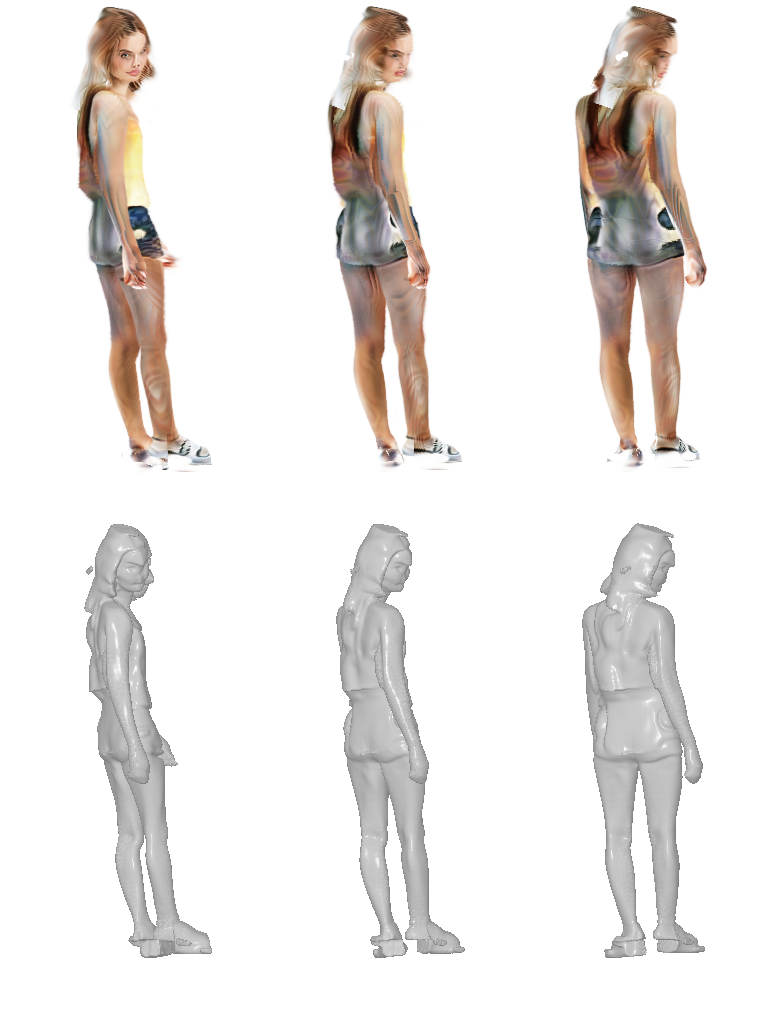

In [19]:
# @title Run inference: Rotation
!python generation_demo.py --batch 1 --chunk 1 --expname 512x256_deepfashion --dataset_path /content/EVA3D/datasets/DeepFashion --depth 5 --width 128 --style_dim 128 --renderer_spatial_output_dim 512 256 --input_ch_views 3 --white_bg --voxhuman_name eva3d_deepfashion --deltasdf --N_samples 28 --ckpt 420000 --identities 1 --truncation_ratio 0.5 --testing_list /content/EVA3D/file_test1.txt
from IPython.display import Image
Image('evaluations/512x256_deepfashion/iter_0420000/random_angles/images_paper_fig/0000000.png')

Input Image


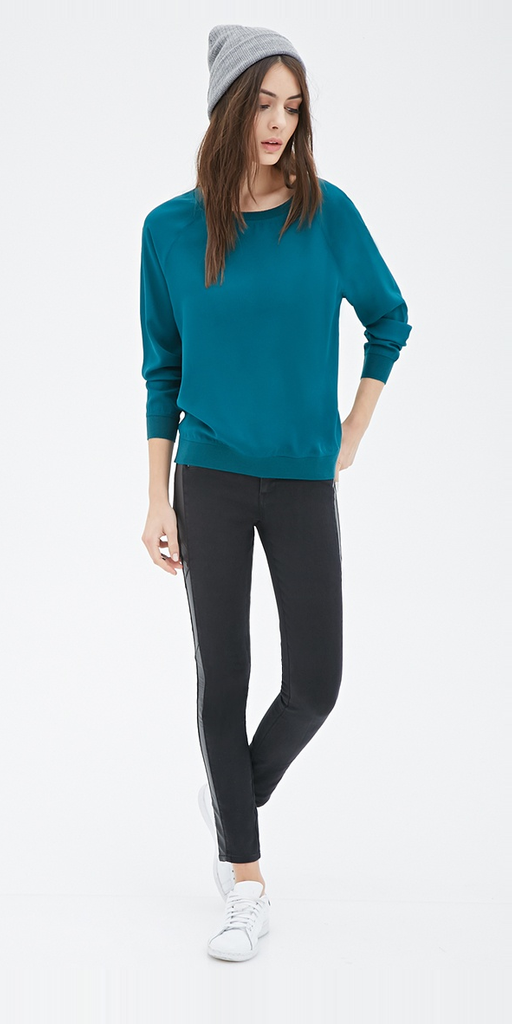

Output Image


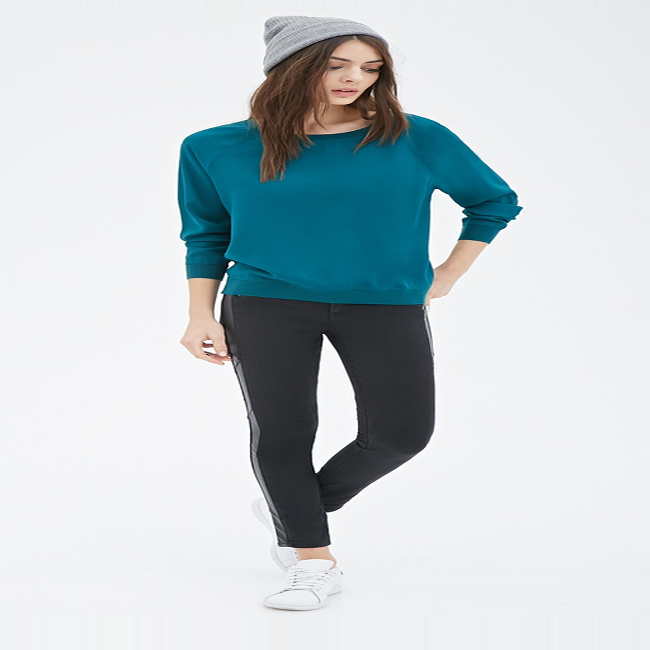

/content/EVA3D/datasets/DeepFashion/images/WOMEN-Blouses_Shirts-id_00001722-07_7_additional__scale.png


In [20]:
# @title Transformation: Scale
image = cv2.imread(img_testing3)
# Scale
# Se aplica la transformación de escalamiento en tamaño
# de 650x650 pixeles.
# y no se aplica ningún escalamiento.
imageOut = cv2.resize(image,(650,650), interpolation=cv2.INTER_CUBIC)
print('Input Image')
cv2_imshow(image)
print('Output Image')
cv2_imshow(imageOut)
output_img_path = img_testing3[:-4]+"__scale.png"
print(output_img_path)
cv2.imwrite(output_img_path, imageOut)
cv2.waitKey(0)
cv2.destroyAllWindows()
# Se guarda la imagen para su posterior inferencia
# en el modelo.
# save basename image to file for inference
with open("file_test1.txt", "w") as ft1:
  ft1.write(os.path.basename(output_img_path))

/usr/local/lib/python3.9/dist-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
image num: 1
smpl num: 1
  0% 0/1 [00:00<?, ?it/s]Marching Cube: 0/5
Marching Cube: 1/5
Marching Cube: 2/5
Marching Cube: 3/5
Marching Cube: 4/5
/usr/local/lib/python3.9/dist-packages/pytorch3d/io/obj_io.py:542: UserWarning: No mtl file provided
  warnings.warn("No mtl file provided")
/usr/local/lib/python3.9/dist-packages/torchvision/utils.py:63: UserWarning: The parameter 'range' is deprecated since 0.12 and will be removed in 0.14. Please use 'value_range' instead.
  warnings.warn(
100% 1/1 [00:26<00:00, 26.39s/it]


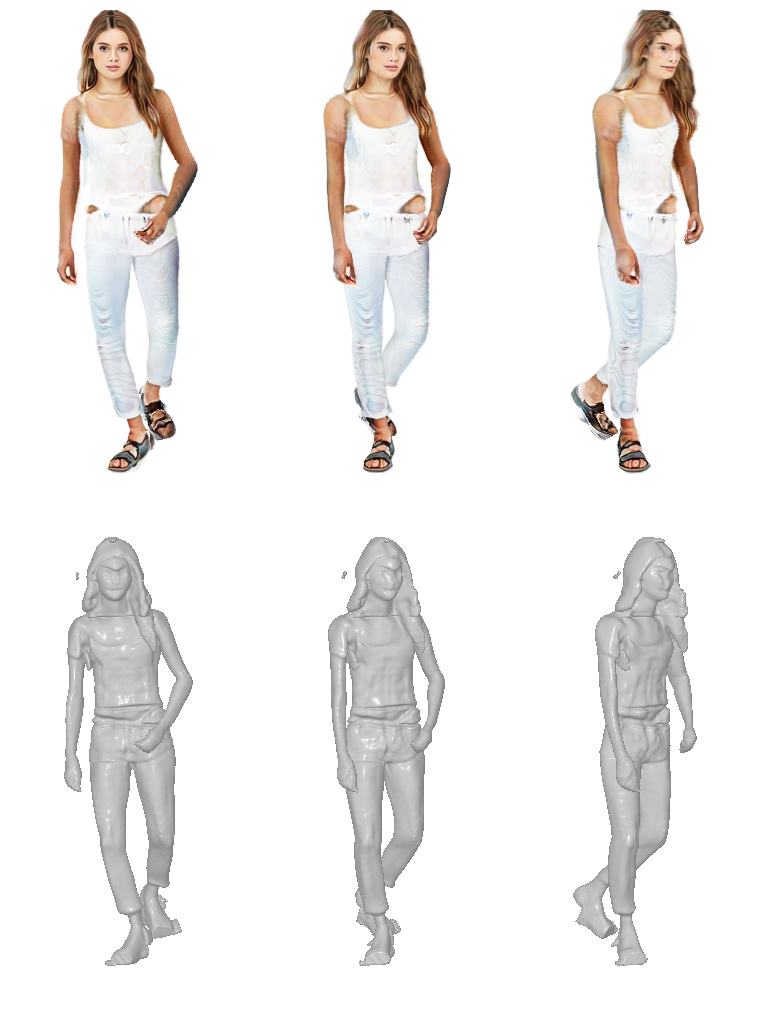

In [21]:
# @title Run inference: Scale
!python generation_demo.py --batch 1 --chunk 1 --expname 512x256_deepfashion --dataset_path /content/EVA3D/datasets/DeepFashion --depth 5 --width 128 --style_dim 128 --renderer_spatial_output_dim 512 256 --input_ch_views 3 --white_bg --voxhuman_name eva3d_deepfashion --deltasdf --N_samples 28 --ckpt 420000 --identities 1 --truncation_ratio 0.5 --testing_list /content/EVA3D/file_test1.txt
from IPython.display import Image
Image('evaluations/512x256_deepfashion/iter_0420000/random_angles/images_paper_fig/0000000.png')

#Conclusiones

Se evalúa aplicando inferencias en el modelo propuesto por los autores del artículo.

Se realizaron las siguientes transformaciones: Rotación, escalamiento y traslación en las imágenes.

Las salidas demuestran que el modelo es capaz de recrear las representaciones 3D
a partir de las observaciones 2D.

Se requiere realizar más experimentación en las evaluaciones, cambio de parámetros con el fin de mejorar los resultados obtenidos.
